# **Problem Statement**
Identify which questions asked on Quora are duplicates of questions that have already been asked.This could be useful to instantly provide answers to questions that have already been answered.We are tasked with predicting whether a pair of questions are duplicates or not.

---

# **Prerocessing** 

* Regular Expression 
* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.
---

# **Methodlgy**

* Used Hand-craft Featurs and Fuzzy String matching based features 
* TF-IDF word Embedding and Weighted TF-IDF Glove(Word2vec) vectorization
* ML Model -> SVM and Logistic Regression with Hyparparameter Tuning.

---

**Results**
* Performance by using TF-IDF
* Performance by Using TF-IDF weighted Glove(W2Vec)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
path = '/content/drive/MyDrive/Personal_Project/Quora_DataSets'
import os
os.chdir('/content/drive/MyDrive/Personal_Project/Quora_DataSets')

In [2]:
!unzip '/content/drive/MyDrive/Personal_Project/quora-question-pairs.zip'

unzip:  cannot find or open /content/drive/MyDrive/Personal_Project/quora-question-pairs.zip, /content/drive/MyDrive/Personal_Project/quora-question-pairs.zip.zip or /content/drive/MyDrive/Personal_Project/quora-question-pairs.zip.ZIP.


In [ ]:
!unzip '/content/drive/MyDrive/Personal_Project/Quora_DataSets/test.csv.zip'

Archive:  /content/drive/MyDrive/Personal_Project/Quora_DataSets/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: Val.csv
  inflating: Val.csv                 


In [ ]:
!unzip '/content/drive/MyDrive/Personal_Project/Quora_DataSets/train.csv.zip'

y
Archive:  /content/drive/MyDrive/Personal_Project/Quora_DataSets/train.csv.zip
  inflating: train.csv               


In [4]:
data = os.listdir(path)

In [5]:
data

['train.csv', 'Val.csv', 'test.csv', '.ipynb_checkpoints']

# **DataSets**

In [31]:
# installing extra packages
!pip install distance
!pip install fuzzywuzzy

     |████████████████████████████████| 180 kB 4.7 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16276 sha256=247d5ac4692e785fc34ea3c7f20e3ffa156228ec02b5049f42434ce10f91ce43
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import os
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [12]:
train_data = pd.read_csv(path + '/' + data[0])
train_data.shape

(404290, 6)

In [13]:
train_data.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
286848,286848,407511,262472,What is the best strategy for getting 3 stars ...,Clash of Clans: Which is best war base for tow...,0
233619,233619,257212,317898,Would there still be web hosting without net n...,Could people still make a website without net ...,1
232584,232584,342627,342628,How do politicians get decent sleep in the mid...,How do I go back to sleep after waking up?,0
227427,227427,336272,27805,"Why, in India, is there a big difference in PC...",Why are console games more expensive than PC v...,0
88427,88427,148729,148730,Am I too old to start learning how to program ...,"I am 29, I want to learn programming, Is it to...",1
330344,330344,457096,457097,What are the best car batteries in Canada?,What is the best car battery?,0
241851,241851,19273,92435,How can I be a good software engineer?,What should I learn to be a software engineer?,1
82201,82201,74089,44868,Can I make an Android app with Python?,How do I make an Android app with Python? I wa...,1
229543,229543,338866,338867,How do I remove anundoram borooah award logo f...,How do designers create a logo from scratch?,0
273517,273517,391988,373992,Can multiple individual viruses infect one cell?,Could a virus infect a virus/other harmful for...,0


In [34]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [14]:
# missing values
train_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [36]:
train_data[train_data.isnull().any(axis=1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [37]:
train_data = train_data.dropna()
train_data.shape

(404287, 6)

In [15]:
# duplicate rows
train_data.duplicated().sum()

0

0    255024
1    149263
Name: is_duplicate, dtype: int64

-------------------------------------------
Lets see in Percentage
-------------------------------------------

0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64



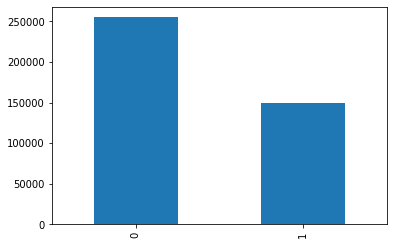

In [38]:
# Distribution of duplicate and non-duplicate questions

print(train_data['is_duplicate'].value_counts())
print()
print('-------------------------------------------')
print('Lets see in Percentage')
print('-------------------------------------------')
print()
print((train_data['is_duplicate'].value_counts()/train_data['is_duplicate'].count())*100)
print()
train_data['is_duplicate'].value_counts().plot(kind='bar')

In [40]:
qids = pd.Series(train_data.qid2.tolist() + train_data.qid1.tolist())
uniq = len(np.unique(qids))
print('Total number of unique questions is {}'.format(uniq))
#Number of questions that repeated than 1 time
cnt = qids.value_counts()
more1 = len(cnt[cnt.values > 1])
print('Number of questions that repeated more than 1 time is {} which is {}%'.format(more1,(more1/(len(cnt))*100)))
print('The maximum number of times a question occured is {}'.format(max(cnt)))

Total number of unique questions is 537929
Number of questions that repeated more than 1 time is 111778 which is 20.779322178205675%
The maximum number of times a question occured is 157


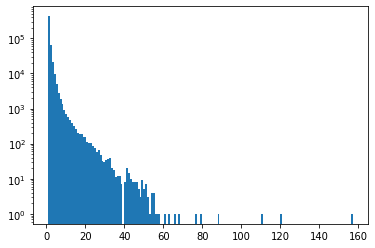

In [41]:
# Repeated questions histogram
plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

# **Feature Engineering Part - 1 (Basic)**

* **freq_qid1** = Frequency of qid1's #ie, number of times question1 occur
* **freq_qid2** = Frequency of qid2's
* **q1len** = Length of q1
* **q2len** = Length of q2
* **q1_n_words** = Number of words in Question 1
* **q2_n_words** = Number of words in Question 2
* **word_Common** = (Number of common unique words in Question 1 and Question 2)
* **word_Total** =(Total num of words in Question 1 + Total num of words in Question 2)
* **word_share** = (word_common)/(word_Total)
* **freq_q1+freq_q2** = sum total of frequency of qid1 and qid2
* **freq_q1-freq_q2** = absolute difference of frequency of qid1 and qid2

In [19]:
os.chdir('/content/drive/MyDrive/Personal_Project/Feature_Engineering/Basic_Preprocess_File')

In [44]:
def common_wrd(row):
    x = set(row['question1'].lower().strip().split(" ")) 
    y = set(row['question2'].lower().strip().split(" "))
    return 1.0 * len(x & y)


def total(row):
    set1 = set(row['question1'].lower().strip().split(" "))
    set2 = set(row['question2'].lower().strip().split(" "))
    return 1.0 * (len(set1) + len(set2))

def word_share(row):
    x = row['word_common']/row['word_total']
    return  x

############################################
train_data['freq_qid1'] = train_data['qid1'].apply(lambda x: cnt[x])
train_data['freq_qid2'] = train_data['qid2'].apply(lambda x: cnt[x])    
train_data['q1len'] = train_data['question1'].apply(lambda x: len(x))
train_data['q2len'] = train_data['question2'].apply(lambda x: len(x))
train_data['q1_n_words'] = train_data['question1'].apply(lambda x: len(x.split(" ")))
train_data['q2_n_words'] = train_data['question2'].apply(lambda x: len(x.split(" ")))
train_data['word_common'] = train_data.apply(common_wrd,axis=1)
train_data['word_total'] = train_data.apply(total,axis=1)
train_data['word_share'] = train_data.apply(word_share,axis=1)
train_data['freq_q1+q2'] = train_data['freq_qid1']+train_data['freq_qid2']
train_data['freq_q1-q2'] = abs(train_data['freq_qid1']-train_data['freq_qid2'])
train_data.to_csv("Preprocessing_Part_1.csv", index=False)

In [45]:
train_data = pd.read_csv('/content/drive/MyDrive/Personal_Project/Feature_Engineering/Basic_Preprocess_File/Preprocessing_Part_1.csv')
train_data.sample(3)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
178218,178219,273778,273779,Could I buy the Verizon version of the Google ...,How can a Quora answer be seen if it’s the 100...,0,122,101,26,20,1,1,2.0,37.0,0.054054,2,0
80871,80871,137411,137412,How I study for upsc exam?,What books should I study for upsc exam?,0,26,40,6,8,1,1,5.0,14.0,0.357143,2,0
57449,57449,100952,100953,"How long did it take for you to get 9,000 foll...","How long did it take for you to get 1,000 foll...",0,74,74,17,17,3,2,13.0,28.0,0.464286,5,1


In [46]:
print ("Minimum length of the questions in question1 : " , min(train_data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(train_data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", train_data[train_data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", train_data[train_data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


In [47]:
train_data[train_data['q1_n_words']== 1].head(3)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
3306,3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,56,1,10,1,1,0.0,10.0,0.0,2,0
13016,13016,25026,25027,?,Why should one not work at Google?,0,1,34,1,7,2,2,0.0,8.0,0.0,4,0
17682,17682,33561,33562,deleted,Which website will be suitable for downloading...,0,7,67,1,10,7,1,0.0,11.0,0.0,8,6


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


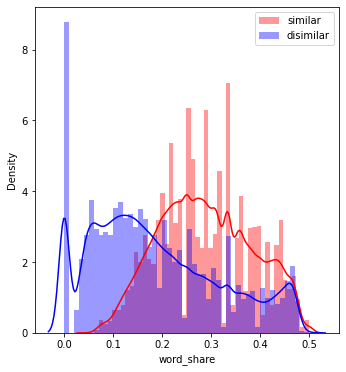

In [53]:
plt.figure(figsize=(12,6))
#plt.subplot(2,1)
#sns.violinplot(x='is_duplicate',y='word_share',train_data=train_data)
plt.subplot(1,2,2)
sns.distplot(train_data[train_data['is_duplicate'] == 1]['word_share'],color='red',label='similar')
sns.distplot(train_data[train_data['is_duplicate'] == 0]['word_share'],color='blue',label='disimilar')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


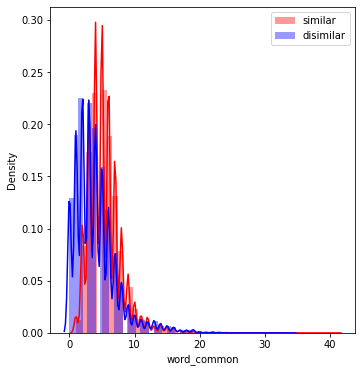

In [55]:
plt.figure(figsize=(12,6))
#plt.subplot(1,2,1)
#sns.violinplot(x='is_duplicate',y='word_common',train_data=train_data)
plt.subplot(1,2,2)
sns.distplot(train_data[train_data['is_duplicate'] == 1]['word_common'],color='red',label='similar')
sns.distplot(train_data[train_data['is_duplicate'] == 0]['word_common'],color='blue',label='disimilar')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


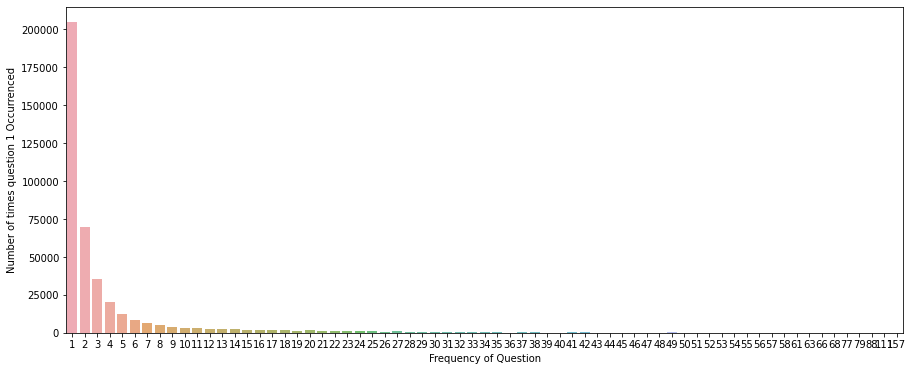

In [56]:
# Frequency of Question 1
plt.figure(figsize=(15,6))
my_count = train_data['freq_qid1'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 1 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


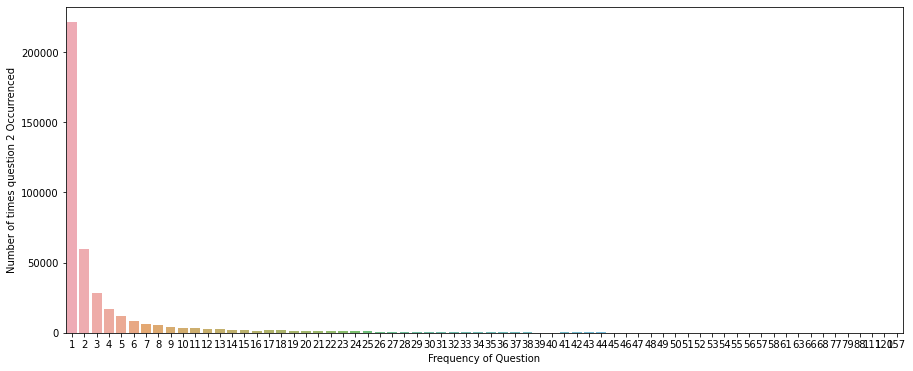

In [57]:
# Frequency of Question 2
plt.figure(figsize=(15,6))
my_count = train_data['freq_qid2'].value_counts()
sns.barplot(my_count.index, my_count.values, alpha=0.8)
plt.ylabel('Number of times question 2 Occurrenced', fontsize=10)
plt.xlabel('Frequency of Question', fontsize=10)
plt.show()

# **Adavanced Feature Engineering**
Text Preprocessing(Cleaning)

* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [58]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [59]:
STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #replacing multiple digits representation to  miilion,thoudsands etc.. eg:1000 -> 1k
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)  
    
    
    porter = PorterStemmer()    #apply stemming  eg: growing,growth --> grow
    pattern = re.compile('\W')  #matching word charecter
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

# **Advanced Features**
**Token Features**

* **cwc_min:** This is the ratio of the number of common words to the length of the smaller question
* **cwc_max:** This is the ratio of the number of common words to the length of the larger question
* **csc_min:** This is the ratio of the number of common stop words to the smaller stop word count among the two questions
* **csc_max:** This is the ratio of the number of common stop words to the larger stop word count among the two questions
* **ctc_min:** This is the ratio of the number of common tokens to the smaller token count among the two questions
* **ctc_max:** This is the ratio of the number of common tokens to the larger token count among the two questions
* **last_word_eq:** 1 if the last word in the two questions is same, 0 otherwise
* **first_word_eq:** 1 if the first word in the two questions is same, 0 otherwise

**Length Based Features**
* **mean_len:** Mean of the length of the two questions (number of words)
* **abs_len_diff:** Absolute difference between the length of the two questions (number of words)
* **longest_substr_ratio:** Ratio of the length of the longest substring among the two questions to the length of the smaller question

**Fuzzy Features**
* **fuzz_ratio:** fuzz_ratio score from fuzzywuzzy
* **fuzz_partial_ratio:** fuzz_partial_ratio from fuzzywuzzy
* **token_sort_ratio:** token_sort_ratio from fuzzywuzzy
* **token_set_ratio:** token_set_ratio from fuzzywuzzy

In [62]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    SAFE_DIV = 0.0001 
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))      # will return longest common substring 
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # To get the results in 4 decemal points
    
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [60]:
os.chdir('/content/drive/MyDrive/Personal_Project/Feature_Engineering/Advance_Peprocessing _file')

In [63]:
df = extract_features(train_data)
df.to_csv("Preprocess_part_2.csv", index=False)

token features...
fuzzy features..


In [64]:
df = pd.read_csv("/content/drive/MyDrive/Personal_Project/Feature_Engineering/Advance_Peprocessing _file/Preprocess_part_2.csv")
print(df.shape)
df.head(2)

(404287, 32)


,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [65]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

In [66]:
sent_dup =np.dstack([df_duplicate['question1'].values,df_duplicate['question2'].values])
#words_dup = [word for sublist in sent_dup for word in sublist]
words_dup = sent_dup.flatten()
######
sent_ndup =np.dstack((df_nonduplicate['question1'].values,df_nonduplicate['question2'].values))
#words_ndup = [word for sublist in sent_ndup for word in sublist]
words_ndup = sent_ndup.flatten()

In [67]:
textp_w = words_dup
#open(path.join(d, 'train_p.txt')).read()
textn_w = words_ndup
#open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))


textn_w = [str(i) for i in textn_w]
textp_w = [str(i) for i in textp_w]
textp_w = ''.join(textp_w)
textn_w = ''.join(textn_w)

Total number of words in duplicate pair questions : 298526
Total number of words in non duplicate pair questions : 510048


Word Cloud for Duplicate Question pairs


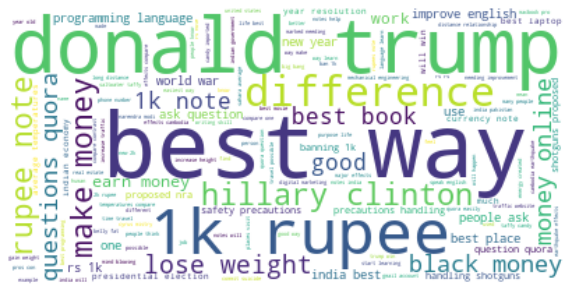

In [72]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for Non Duplicate Question pairs


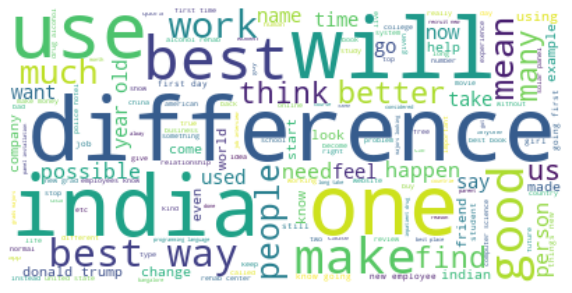

In [73]:
wc = WordCloud(background_color="white", max_words=len(textn_w), stopwords=stopwords)
wc.generate(textn_w)
print ("Word Cloud for Non Duplicate Question pairs")
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

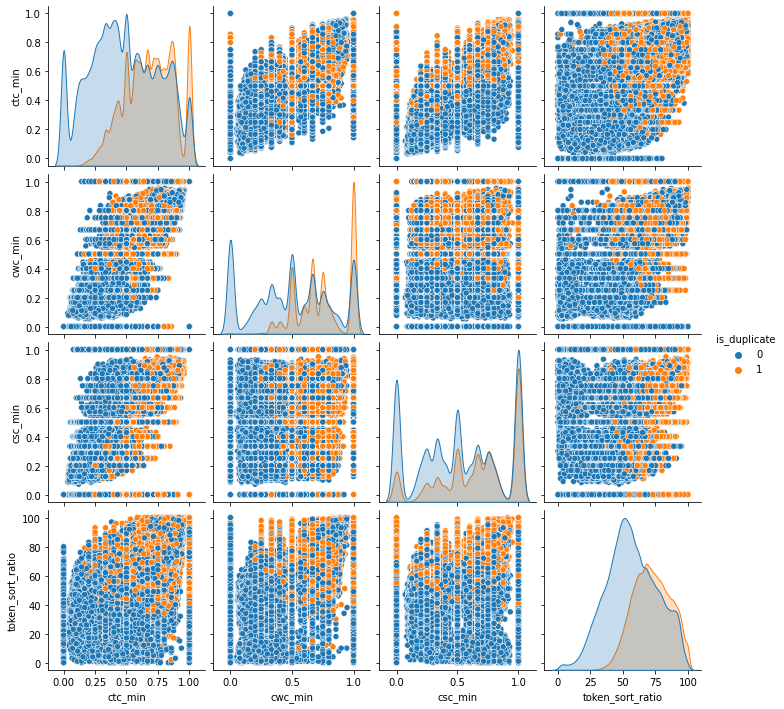

<Figure size 1152x576 with 0 Axes>

In [70]:
sns.pairplot(df, hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.figure(figsize=(10,8))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


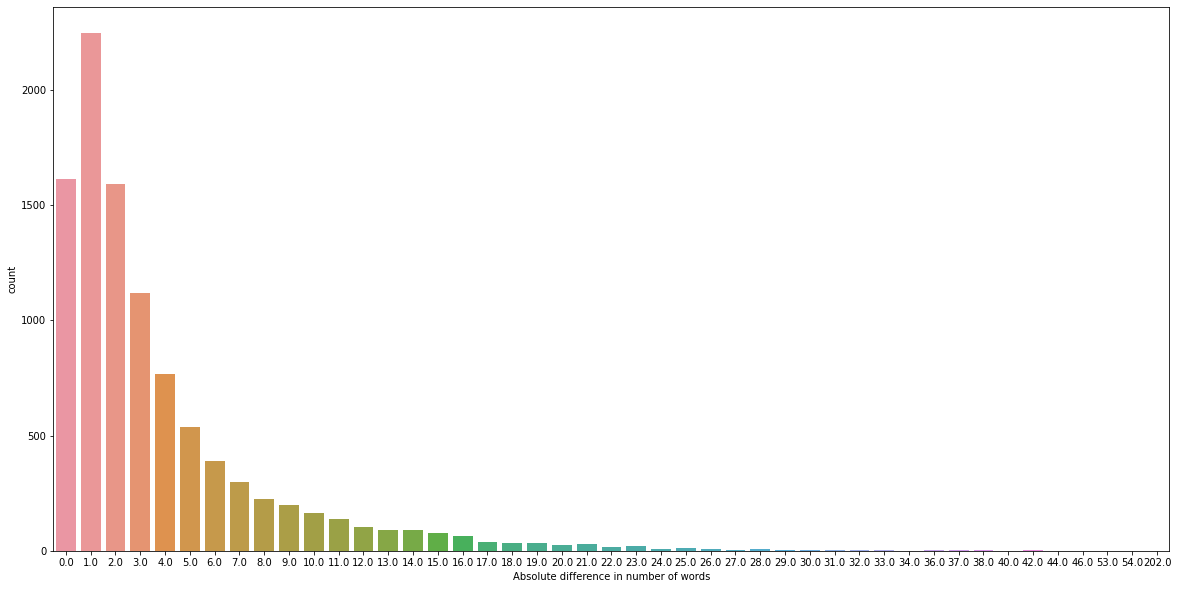

In [71]:
plt.figure(figsize=(12, 10))
dist = df['abs_len_diff'][0:10000].values
dist.min()
plt.xlabel('Absolute difference in number of words')
sns.countplot(dist)
plt.show()

In [74]:
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 0.363s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.267s
[t-SNE] Iteration 50: error = 81.3240433, gradient norm = 0.0460679 (50 iterations in 2.582s)
[t-SNE] Iteration 100: error = 70.6469879, gradient norm = 0.0087808 (50 iterations in 1.855s)
[t-SNE] Iteration 150: error = 68.9435196, gradient norm = 0.0062571 (50 iterations in 1.709s)
[t-SNE] Iteration 200: error = 68.1250000, gradient norm = 0.0042800 (50 iterations in 1.782s)
[t-SNE] Iteration 250: error = 67.6175537, gradient norm = 0.0032984

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


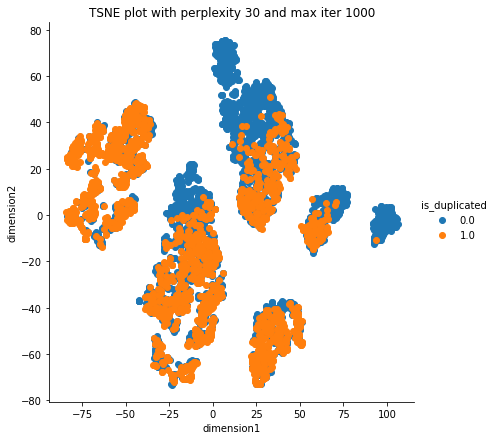

In [75]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)
#tsne result will appear as 2 columns.We have to plot it
# creating a new data frame which help us in ploting the tsne_result
tsne_new = np.vstack((tsne2d.T,dfp_subsampled['is_duplicate'])).T
df = pd.DataFrame(data=tsne_new, columns=("dimension1", "dimension2",
"is_duplicated"))
# Ploting the result
sns.FacetGrid(df, hue="is_duplicated", size=6).map(plt.scatter, 'dimension1',
'dimension2').add_legend()
plt.title("TSNE plot with perplexity 30 and max iter 1000")
plt.show()

# **Features Extraction (Text Vectorization)**

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
from scipy.sparse import hstack
import os , pickle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm

import spacy

In [79]:
df = pd.read_csv('/content/drive/MyDrive/Personal_Project/Feature_Engineering/Advance_Peprocessing _file/Preprocess_part_2.csv')
df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1_n_words,q2_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,66,57,14,12,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,51,88,8,13,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,73,59,14,10,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,50,65,11,9,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,76,39,13,7,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [80]:
#sampling 100k
df = df.sample(n=100000,random_state=40)

In [81]:
#changing columns to numeric type
num_cols = df.drop(columns=['id', 'qid1', 'qid2', 'question1', 'question2']).columns
for i in num_cols:
    df[i] = df[i].apply(pd.to_numeric)

In [82]:
y = df['is_duplicate']
X = df[df.drop(columns=['id', 'qid1', 'qid2','is_duplicate']).columns.tolist()]
print(X.shape)
print(y.shape)

(100000, 28)
(100000,)


In [83]:
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3,random_state=100)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 28)
Number of data points in test data : (30000, 28)


# **Word Embeding**

* TFIDF
* TFIDF weighted glove vectorization

In [89]:
X_train['question1'] = X_train['question1'].dropna()

In [92]:
tfidf_vectorizer1 = TfidfVectorizer(lowercase=False,max_features= 20000)
trainqs1_tfidf = tfidf_vectorizer1.fit_transform(X_train['question1'].values.astype('U'))
testqs1_tfidf  = tfidf_vectorizer1.transform(X_test['question1'].values.astype('U'))
print(trainqs1_tfidf.shape)
print(testqs1_tfidf.shape)

(70000, 20000)
(30000, 20000)


In [93]:
tfidf_vectorizer2 = TfidfVectorizer(lowercase=False,max_features= 20000)
train_qs2_tfidf = tfidf_vectorizer2.fit_transform(X_train['question2'].values.astype('U'))
test_qs2_tfidf  = tfidf_vectorizer2.transform(X_test['question2'].values.astype('U'))
print(train_qs2_tfidf.shape)
print(test_qs2_tfidf.shape)

(70000, 20000)
(30000, 20000)


In [97]:
#Now we will hstack both the vectors
tfidf_train_vec = hstack((trainqs1_tfidf,train_qs2_tfidf))
tfidf_test_vec = hstack((testqs1_tfidf,test_qs2_tfidf)) 
print("train data shape",tfidf_train_vec.shape)
print("Test data shape ",tfidf_test_vec.shape)

train data shape (70000, 40000)
Test data shape  (30000, 40000)


In [94]:
# selecting other features
train_df = X_train.drop(columns=['question1', 'question2'])
test_df = X_test.drop(columns=['question1', 'question2'])

In [95]:
#we need to convert our data with features into sparse matrix so that we can combine our feature matrix and and tfidf vectors 
import scipy
train_sparse = scipy.sparse.csr_matrix(train_df)
test_sparse = scipy.sparse.csr_matrix(test_df)

In [98]:
# Now combining our tfidf and features into one 
tfidf_X_tr = hstack((train_sparse,tfidf_train_vec))
tfidf_X_test = hstack((test_sparse,tfidf_test_vec))
print("train data shape",tfidf_X_tr.shape)
print("Test data shape ",tfidf_X_test.shape)

train data shape (70000, 40026)
Test data shape  (30000, 40026)


In [99]:
os.chdir('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFIDF')

In [100]:
#saving tfidf vectors
pickle.dump(tfidf_train_vec, open("tfidf_X_train","wb"))
pickle.dump(tfidf_test_vec, open("tfidf_X_test","wb"))

# **TFIDF Weighted Glove Vectors**

In [109]:
questions = list(X_train['question1'].values.astype('U')) + list(X_train['question2'].values.astype('U'))
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [110]:
# Load the spacy model that you have installed
import en_core_web_sm
nlp = en_core_web_sm.load()

# each vector will be of length 94..
doc = nlp("This is some text that I am processing with Spacy")
#example
doc[3].vector.shape

(96,)

In [121]:
X_train['question1'] = X_train['question1'].values.astype('str')

In [122]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for i,word1 in enumerate(doc1):
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1[i] += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

X_train_glove_q1 = vecs1

100%|██████████| 70000/70000 [10:43<00:00, 108.73it/s]


In [123]:
X_train['question2'] = X_train['question2'].values.astype('str')

In [124]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for i,word1 in enumerate(doc1):
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1[i] += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

X_train_glove_q2 = vecs1

100%|██████████| 70000/70000 [11:18<00:00, 103.21it/s]


In [126]:
X_test['question1'] = X_test['question1'].values.astype('str')

In [127]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for i,word1 in enumerate(doc1):
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1[i] += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

X_test_glove_q1 = vecs1

100%|██████████| 30000/30000 [05:40<00:00, 88.03it/s] 


In [128]:
X_test['question2']  = X_test['question2'].values.astype('str')

In [129]:
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for i,word1 in enumerate(doc1):
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1[i] += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

X_test_glove_q2 = vecs1

100%|██████████| 30000/30000 [04:47<00:00, 104.42it/s]


In [130]:
X_train['q1_glove'] = X_train_glove_q1
X_train['q2_glove'] = X_train_glove_q2
X_test['q1_glove'] = X_test_glove_q1
X_test['q2_glove'] = X_test_glove_q2

In [131]:
train_glove = np.concatenate([np.array(X_train_glove_q1),np.array(X_train_glove_q2)],axis=1)
test_glove = np.concatenate([np.array(X_test_glove_q1),np.array(X_test_glove_q2)],axis=1)
train_glove.shape

(70000, 192)

In [132]:
glove_train_df = pd.DataFrame(train_glove,columns=[f'g_{i}' for i in range(train_glove.shape[1])])
glove_test_df = pd.DataFrame(test_glove,columns=[f'g_{i}' for i in range(test_glove.shape[1])])
glove_train_df.head()

,g_0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,8.620377,-1.614727,-2.521583,-1.531998,2.092236,0.767564,5.339287,3.058473,10.082106,11.054510,...,-2.701354,2.716441,-0.510052,6.447781,-2.949746,-0.962468,2.531881,6.010862,1.527958,1.486945
1,-0.976643,-2.725152,2.448420,-6.019244,10.633596,-0.612285,2.808925,2.506091,3.439625,2.748850,...,3.914964,0.328768,-2.454020,0.270393,-9.784351,-0.421203,2.982829,3.221098,-0.517070,7.156083
2,1.364633,-0.612766,-0.917767,4.277427,10.759067,7.220730,2.623590,2.577329,10.591618,13.758568,...,-2.047053,-4.732654,-0.826601,6.169578,0.445108,-2.095889,4.520428,-1.048259,0.624426,6.458432
3,-5.402827,-1.453848,-3.300925,0.197813,1.619330,6.634061,1.017171,3.348628,1.350459,7.710702,...,-0.772201,1.317268,-5.662102,1.054329,-6.430517,-1.770199,-3.266285,1.832004,6.204855,4.190380
4,6.240948,-0.342004,0.272171,7.702876,3.548724,2.831506,9.050959,0.379950,8.114947,9.188508,...,-2.429725,0.942915,-4.174390,8.085426,0.507519,-9.277117,4.342348,1.404644,5.940545,5.478593


In [133]:
X_train = X_train.drop(columns=['question1','question2']).reset_index(drop=True)
X_test = X_test.drop(columns=['question1','question2']).reset_index(drop=True)
print(X_train.shape)
print(X_test.shape)

(70000, 28)
(30000, 28)


In [134]:
# concatenating
X_train_d = pd.concat([X_train,glove_train_df],axis=1)
X_test_d = pd.concat([X_test,glove_test_df],axis=1)
print(X_train_d.shape)
print(X_test_d.shape)

(70000, 220)
(30000, 220)


In [135]:
os.chdir('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V')

In [136]:
X_train_d.to_csv('_tfidf_w2vtrain_data.csv',index=False)
X_test_d.to_csv('tfidf_w2v_test_data.csv',index=False)

In [137]:
y_train.to_csv('tfidf_w2v_train_y.csv',index=False)
y_test.to_csv('tfidf_w2v_testa_y.csv',index=False)

# **Machine Learning Model**

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os,pickle
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

## **ML On TF-IDF Weighted W2V**

In [154]:
#loading tfidf weighted glove
X_train = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/_tfidf_w2vtrain_data.csv')
X_test = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_test_data.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_train_y.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_test_y.csv')
X_train = X_train.drop(columns=['q1_glove','q2_glove'])
X_test = X_test.drop(columns=['q1_glove','q2_glove'])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 218)
(30000, 218)
(70000, 1)
(30000, 1)


In [149]:
X_train.head(3)

,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,54,56,10,10,1,1,6.0,19.0,0.315789,2,...,-2.701354,2.716441,-0.510052,6.447781,-2.949746,-0.962468,2.531881,6.010862,1.527958,1.486945
1,56,45,9,8,1,1,8.0,17.0,0.470588,2,...,3.914964,0.328768,-2.454020,0.270393,-9.784351,-0.421203,2.982829,3.221098,-0.517070,7.156083
2,111,96,19,17,4,3,8.0,34.0,0.235294,7,...,-2.047053,-4.732654,-0.826601,6.169578,0.445108,-2.095889,4.520428,-1.048259,0.624426,6.458432


In [150]:
X_test.head(3)

,q1len,q2len,q1_n_words,q2_n_words,freq_qid1,freq_qid2,word_common,word_total,word_share,freq_q1+q2,...,g_182,g_183,g_184,g_185,g_186,g_187,g_188,g_189,g_190,g_191
0,45,51,6,7,14,14,4.0,13.0,0.307692,28,...,3.969435,-4.386923,5.229480,6.589633,-13.695223,-2.685117,8.354160,8.374036,-7.196234,19.219431
1,82,53,13,9,3,1,0.0,21.0,0.000000,4,...,-2.151148,1.043688,1.686962,1.703929,-1.317777,-2.861869,1.587751,2.456052,-3.206597,6.237281
2,66,28,12,6,42,46,4.0,18.0,0.222222,88,...,-1.119629,-1.178872,0.693722,0.528563,2.404150,5.529877,-6.858145,8.659120,-0.890519,1.957024


In [151]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    #[TN FP]
    #[FN TP]   
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #precision = true positive / predicted positive
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #recall = true positive/ actual positive
    #divide each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    # cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True,  fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [156]:
from sklearn.metrics import log_loss

# **Logistic Regression**

For values of alpha =  1e-05 The log loss is: 0.40689619656342363
For values of alpha =  0.0001 The log loss is: 0.4125160759089444
For values of alpha =  0.001 The log loss is: 0.4146485191559921
For values of alpha =  0.01 The log loss is: 0.3943245507998153
For values of alpha =  0.1 The log loss is: 0.4205835577362309
For values of alpha =  1 The log loss is: 0.4551889081715811
For values of alpha =  10 The log loss is: 0.5061304186070562


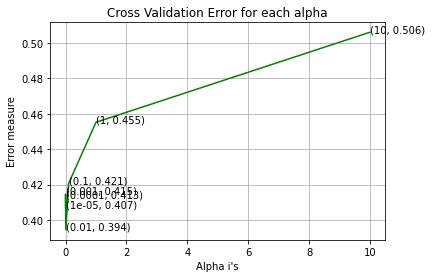

In [157]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.38511126714780586
For values of best alpha =  0.01 The test log loss is: 0.3943245507998153
Total number of data points : 30000


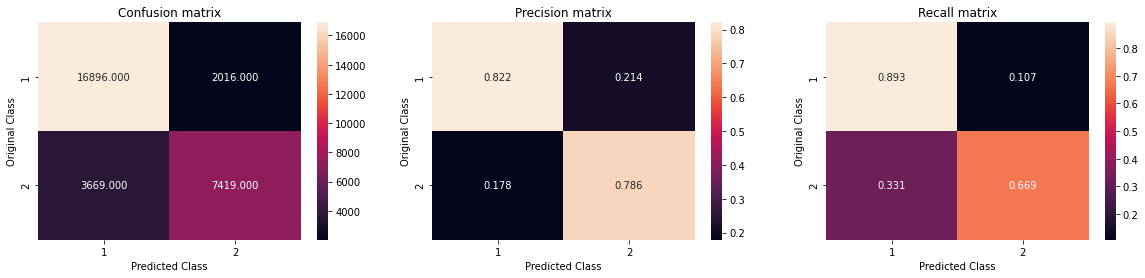

In [161]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [166]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [167]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [169]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [170]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86     18912
           1       0.79      0.67      0.72     11088

    accuracy                           0.81     30000
   macro avg       0.80      0.78      0.79     30000
weighted avg       0.81      0.81      0.81     30000



# **Linear SVM with hinge Loss**

For values of alpha =  1e-05 The log loss is: 0.4060422440236008
For values of alpha =  0.0001 The log loss is: 0.4138589172038047
For values of alpha =  0.001 The log loss is: 0.40756399968904033
For values of alpha =  0.01 The log loss is: 0.39436667438525014
For values of alpha =  0.1 The log loss is: 0.4169084766869477
For values of alpha =  1 The log loss is: 0.4426180713174131
For values of alpha =  10 The log loss is: 0.4924010747968385


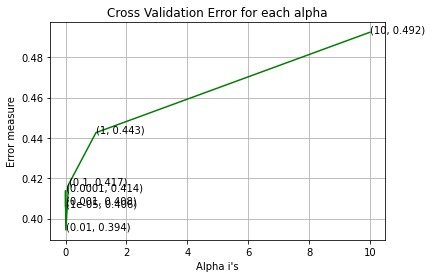

In [171]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.01 The train log loss is: 0.38630324884340106
For values of best alpha =  0.01 The test log loss is: 0.39436667438525014
Total number of data points : 30000


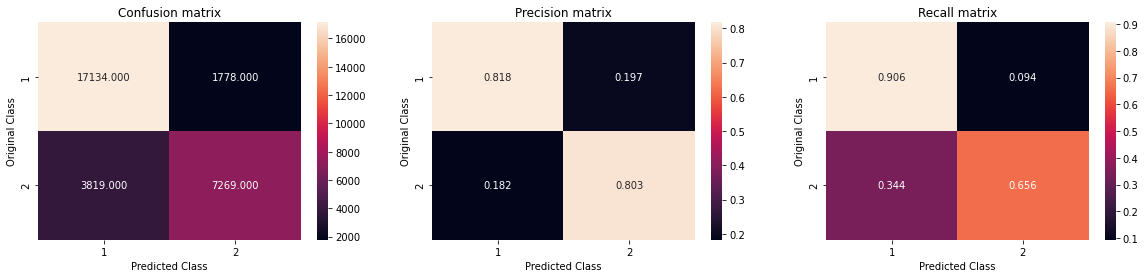

In [172]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [173]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [177]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [178]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [179]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     18912
           1       0.80      0.66      0.72     11088

    accuracy                           0.81     30000
   macro avg       0.81      0.78      0.79     30000
weighted avg       0.81      0.81      0.81     30000



# **ML On TF-IDF**

In [187]:

X_train = pickle.load(open("/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFIDF/tfidf_X_train","rb"))
X_test = pickle.load(open("/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFIDF/tfidf_X_test","rb"))
y_train = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_test_y.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Personal_Project/Fetures_Extraction/TFID_Weighted_W2V/tfidf_w2v_train_y.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(70000, 40000)
(30000, 40000)
(70000, 1)
(30000, 1)


# **Logistic Regression**

For values of alpha =  1e-05 The log loss is: 0.5394247521413
For values of alpha =  0.0001 The log loss is: 0.5439507068818819
For values of alpha =  0.001 The log loss is: 0.5717202692438471
For values of alpha =  0.01 The log loss is: 0.5963944447526353
For values of alpha =  0.1 The log loss is: 0.643332819938788
For values of alpha =  1 The log loss is: 0.6511025880218158
For values of alpha =  10 The log loss is: 0.6518009883305877


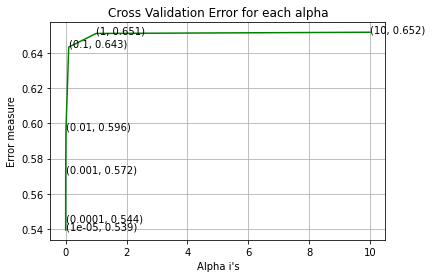

In [188]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  1e-05 The train log loss is: 0.4362013191694408
For values of best alpha =  1e-05 The test log loss is: 0.5394247521413
Total number of data points : 30000


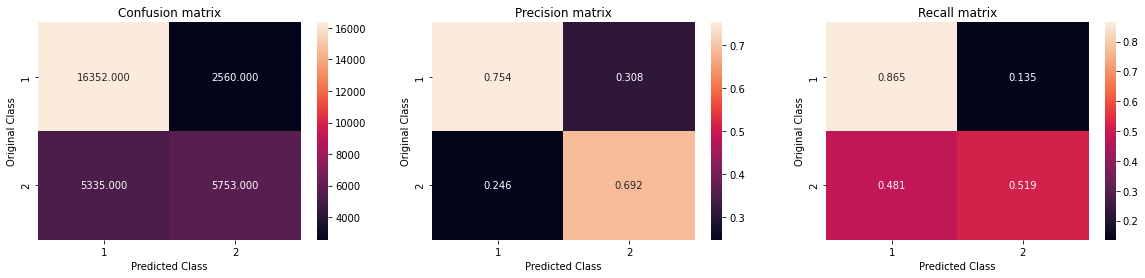

In [189]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [190]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [191]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [192]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [193]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.86      0.81     18912
           1       0.69      0.52      0.59     11088

    accuracy                           0.74     30000
   macro avg       0.72      0.69      0.70     30000
weighted avg       0.73      0.74      0.73     30000



# **Linear SVM with hinge Loss**

For values of alpha =  1e-05 The log loss is: 0.5525064436903558
For values of alpha =  0.0001 The log loss is: 0.5444042421387661
For values of alpha =  0.001 The log loss is: 0.5765658935650594
For values of alpha =  0.01 The log loss is: 0.585242405349183
For values of alpha =  0.1 The log loss is: 0.6518235293362067
For values of alpha =  1 The log loss is: 0.6518235293339621
For values of alpha =  10 The log loss is: 0.6518235293361252


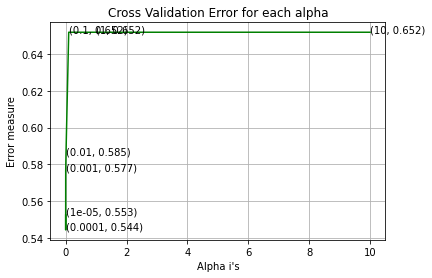

In [194]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

For values of best alpha =  0.0001 The train log loss is: 0.48846721940918764
For values of best alpha =  0.0001 The test log loss is: 0.5444042421387661
Total number of data points : 30000


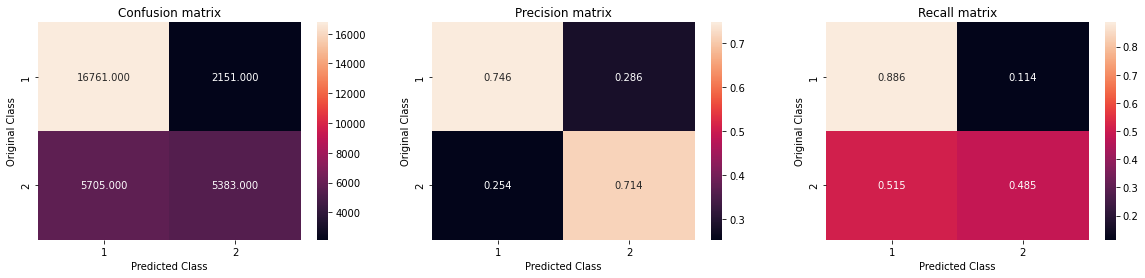

In [195]:
best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [196]:
y_test.values

array([[1],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [197]:
pred = np.argmax(predict_y,axis=1)
pred = pred.reshape(-1,1)

In [198]:
pred

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [199]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     18912
           1       0.71      0.49      0.58     11088

    accuracy                           0.74     30000
   macro avg       0.73      0.69      0.69     30000
weighted avg       0.73      0.74      0.72     30000



# **Results**

In [203]:
from prettytable import PrettyTable
print("TF-IDF w2v")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss", "Accuracy", "Precision", "recall", "f1-score"]

x.add_row(["Logistic Regression",'TF-IDF w2v', 0.385, 0.3942,0.81,  0.80, 0.78 , 0.79 ])
x.add_row(["Linear SVM", 'TF-IDF w2v', 0.387, 0.395, 0.81,  0.81, 0.78 , 0.79])

print(x)




print("\n TF-IDF vec")
x = PrettyTable()
x.field_names = ["ML Model", "Vectorizer", "Train log loss", "Test log loss", "Accuracy", "Precision", "recall", "f1-score"]

x.add_row(["Logistic Regression",'TF-IDF ', 0.436,0.539,  0.74, 0.72, 0.69, 0.70 ])
x.add_row(["Linear SVM", 'TF-IDF ',0.488,0.544, 0.74, 0.73, 0.69, 0.69 ])

print(x)

TF-IDF w2v
+---------------------+------------+----------------+---------------+----------+-----------+--------+----------+
|       ML Model      | Vectorizer | Train log loss | Test log loss | Accuracy | Precision | recall | f1-score |
+---------------------+------------+----------------+---------------+----------+-----------+--------+----------+
| Logistic Regression | TF-IDF w2v |     0.385      |     0.3942    |   0.81   |    0.8    |  0.78  |   0.79   |
|      Linear SVM     | TF-IDF w2v |     0.387      |     0.395     |   0.81   |    0.81   |  0.78  |   0.79   |
+---------------------+------------+----------------+---------------+----------+-----------+--------+----------+

 TF-IDF vec
+---------------------+------------+----------------+---------------+----------+-----------+--------+----------+
|       ML Model      | Vectorizer | Train log loss | Test log loss | Accuracy | Precision | recall | f1-score |
+---------------------+------------+----------------+---------------+---